In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [3]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv

train_file = './data/titanic/train.csv'
eval_file = './data/titanic/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [4]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [5]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


<AxesSubplot:>

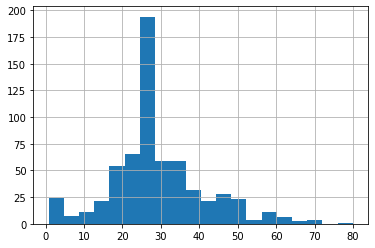

In [7]:
train_df.age.hist(bins=20)

<AxesSubplot:>

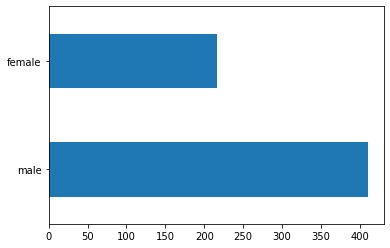

In [8]:
train_df.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

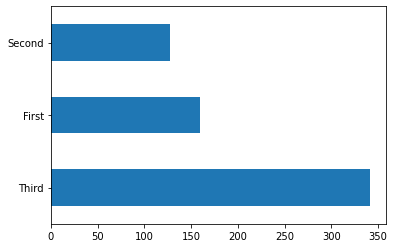

In [9]:
train_df['class'].value_counts().plot(kind='barh')

<AxesSubplot:ylabel='sex'>

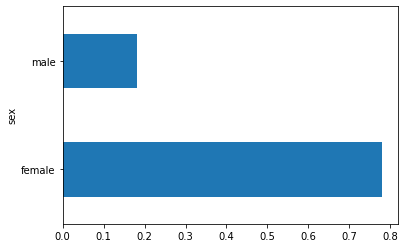

In [10]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [11]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

from pprint import pprint
pprint(feature_columns)

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']
[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCa

In [12]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [13]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [14]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'female', b'male', b'female', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 34., 28., 30., 24.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 3, 0])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([14.4542, 14.4   , 51.8625, 21.    ,  8.05  ])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'First', b'Second', b'Third'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'D', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Cherbourg', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'n', b'n', b'n', b'n', 

In [15]:
# keras.layers.DenseFeature
for x,y in train_dataset.take(1):
    print(x, y)
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 18., 62., 27., 17.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 2])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([  7.8958,  20.2125,  10.5   ,   7.8958, 110.8833])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'C'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'n', b'y', b'y', b

In [16]:
# keras.layers.DenseFeature
for x,y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 9.     1.     0.     1.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    31.275  0.
   0.     0.     1.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     0.     1.   ]
 [18.     1.     0.     0.     0.     1.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    23.     0.
   1.     0.     0.     0.     0.     0.     0.     1.     0.     0.
   0.     0.     0.     1.   ]
 [28.     0.     1.     1.     0

In [17]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])

In [18]:
# 1. model.fit
# 2. model ->estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
history = model.fit(train_dataset, validation_data=eval_dataset,
                   steps_per_epoch=20,
                   validation_steps=8,
                   epochs=100)

Epoch 1/100
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
 1/20 [>.............................] - ETA: 0s - loss: 1.1665 - accuracy: 0.7500WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'n_siblings_spouses': <tf.Tensor 'ExpandDims_

20/20 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.7531 - val_loss: 0.5518 - val_accuracy: 0.7344
Epoch 37/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.7078 - val_loss: 0.5360 - val_accuracy: 0.7305
Epoch 38/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.7297 - val_loss: 0.5437 - val_accuracy: 0.7188
Epoch 39/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5488 - accuracy: 0.7391 - val_loss: 0.5179 - val_accuracy: 0.7266
Epoch 40/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5516 - accuracy: 0.7234 - val_loss: 0.5129 - val_accuracy: 0.7500
Epoch 41/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7250 - val_loss: 0.5174 - val_accuracy: 0.7344
Epoch 42/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.7250 - val_loss: 0.5141 - val_accuracy: 0.7461
Epoch 43/100
20/20 

Epoch 94/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4856 - accuracy: 0.7844 - val_loss: 0.5837 - val_accuracy: 0.7070
Epoch 95/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5264 - accuracy: 0.7625 - val_loss: 0.5488 - val_accuracy: 0.6719
Epoch 96/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.7469 - val_loss: 0.6018 - val_accuracy: 0.7109
Epoch 97/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7922 - val_loss: 0.4914 - val_accuracy: 0.7500
Epoch 98/100
20/20 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7984 - val_loss: 0.4899 - val_accuracy: 0.7461
Epoch 99/100
 0/20 [..............................] - 0s 0s/step - loss: 0.4735 - accuracy: 0.7984 - val_loss: 0.4899 - val_accuracy: 0.7461


In [23]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return a. (features, lables) b.dataset -> (feture, label)
estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8yqu0l4q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas':

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.